**IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.tree import export_text, plot_tree
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load the data
df = pd.read_csv('./data/train_data.csv')
df.head(2)

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
0,2days,₹100000 or More,4~8,1,less1,Married partner,4 star restaurant,36,0,0,...,0,0,4,67,less1,22,Spring,Location B,0,No
1,2days,₹87500 - ₹99999,4~8,0,4~8,Married partner,Take-away restaurant,50plus,0,0,...,0,1,3,89,1~3,18,Summer,Location B,0,Yes


**EDA**

- Summary Statistics

In [3]:
data = df.copy()

# Getting the summary statistics of the dataset
summary_statistics = data.describe(include='all')

# Displaying the summary statistics
summary_statistics.head()


,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
count,12379,12379,12181,12379.000000,12258,12379,12379,12379,12379.000000,12379.000000,...,12379.000000,12379.000000,12379.000000,12379.000000,12219,12379.000000,12379,12379,12379.000000,12379
unique,2,9,5,NaN,5,5,5,8,NaN,NaN,...,NaN,NaN,NaN,NaN,5,NaN,3,3,NaN,2
top,2days,₹25000 - ₹37499,less1,NaN,1~3,Married partner,Cold drinks,21,NaN,NaN,...,NaN,NaN,NaN,NaN,less1,NaN,Summer,Location A,NaN,Yes
freq,6791,2010,3304,NaN,5248,4987,3471,2602,NaN,NaN,...,NaN,NaN,NaN,NaN,5992,NaN,8065,5590,NaN,6994
mean,NaN,NaN,NaN,0.565393,NaN,NaN,NaN,NaN,0.506665,0.119396,...,0.787382,0.415623,1.987802,71.139187,NaN,13.947896,NaN,NaN,0.509815,NaN


- handling missing values

In [7]:
# Identifying the columns with missing values and calculating the percentage of missing data
missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100

# Combining the missing data count and percentage into a DataFrame
missing_info = pd.DataFrame({"Missing Values": missing_data, "Percentage": missing_percentage})

# Formatting the missing percentage with two decimal places followed by a percentage symbol
missing_info['Percentage'] = missing_info['Percentage'].apply(lambda x: f"{x:.2f} %")

# Filtering only the columns with missing values
missing_info = missing_info[missing_info["Missing Values"] > 0]

# Displaying the missing information
missing_info


,Missing Values,Percentage
no_visited_Cold drinks,198,1.60 %
Restaur_spend_less_than20,121,0.98 %
no_visited_bars,93,0.75 %
car,12268,99.10 %
no_Take-aways,144,1.16 %
Restaur_spend_greater_than20,160,1.29 %


In [8]:
# Imputing missing values using the mode for the identified categorical columns
columns_to_impute = ['no_visited_Cold drinks', 'Restaur_spend_less_than20', 
                     'no_visited_bars', 'no_Take-aways', 'Restaur_spend_greater_than20']

for column in columns_to_impute:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

# Removing the 'car' column as it has a high percentage of missing values
data.drop(columns=['car'], inplace=True)

# Checking if the missing values are handled
missing_after_imputation = data.isnull().sum().sum()
missing_after_imputation


0

- Summary Statistics of Cleaned data (Revisited)

In [9]:
# Getting the summary statistics of the cleaned dataset
summary_statistics_cleaned = data.describe(include='all')

# Displaying the summary statistics
summary_statistics_cleaned.head()


,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
count,12379,12379,12379,12379.000000,12379,12379,12379,12379,12379.000000,12379.000000,...,12379.000000,12379.000000,12379.000000,12379.000000,12379,12379.000000,12379,12379,12379.000000,12379
unique,2,9,5,NaN,5,5,5,8,NaN,NaN,...,NaN,NaN,NaN,NaN,5,NaN,3,3,NaN,2
top,2days,₹25000 - ₹37499,less1,NaN,1~3,Married partner,Cold drinks,21,NaN,NaN,...,NaN,NaN,NaN,NaN,less1,NaN,Summer,Location A,NaN,Yes
freq,6791,2010,3502,NaN,5369,4987,3471,2602,NaN,NaN,...,NaN,NaN,NaN,NaN,6152,NaN,8065,5590,NaN,6994
mean,NaN,NaN,NaN,0.565393,NaN,NaN,NaN,NaN,0.506665,0.119396,...,0.787382,0.415623,1.987802,71.139187,NaN,13.947896,NaN,NaN,0.509815,NaN


- Univariate Analysis

Analyzing Single Variables through Histograms, Box Plots, etc.
(Numerical Variables)

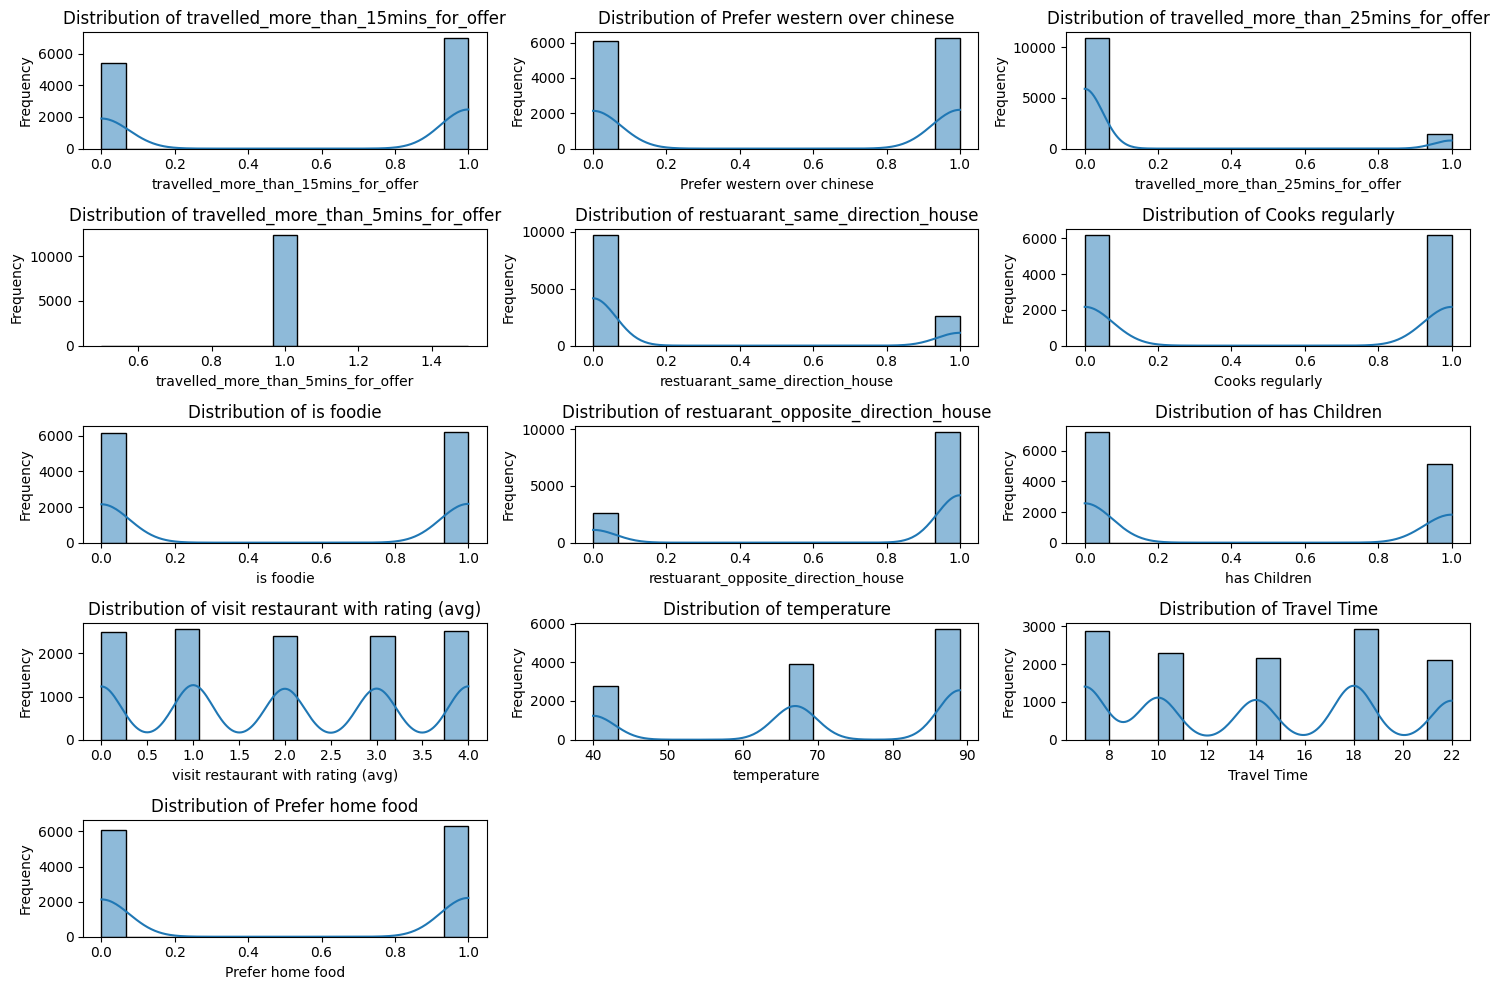

In [10]:
# Determining the number of rows and columns for the subplots
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

num_numerical_columns = len(numerical_columns)
num_rows = (num_numerical_columns // 3) + (1 if num_numerical_columns % 3 != 0 else 0)

# Plotting histograms for numerical variables
plt.figure(figsize=(15, 10))
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 3, idx)
    sns.histplot(data[col], bins=15, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


- Bivariate Analysis

Analyzing the Relationship Between Two Variables

(Scatter Plots)

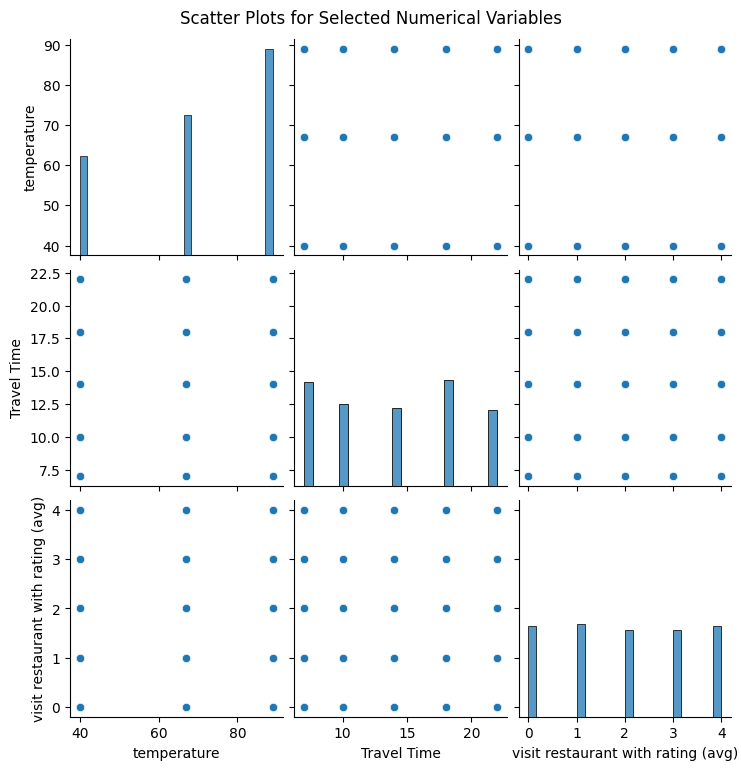

In [11]:
# Selecting a few numerical columns for scatter plot analysis
selected_columns_for_scatter = ['temperature', 'Travel Time', 'visit restaurant with rating (avg)']

# Plotting scatter plots for selected pairs of numerical variables
sns.pairplot(data=data, vars=selected_columns_for_scatter)
plt.suptitle('Scatter Plots for Selected Numerical Variables', y=1.02)
plt.show()


(Correlation Heatmap)

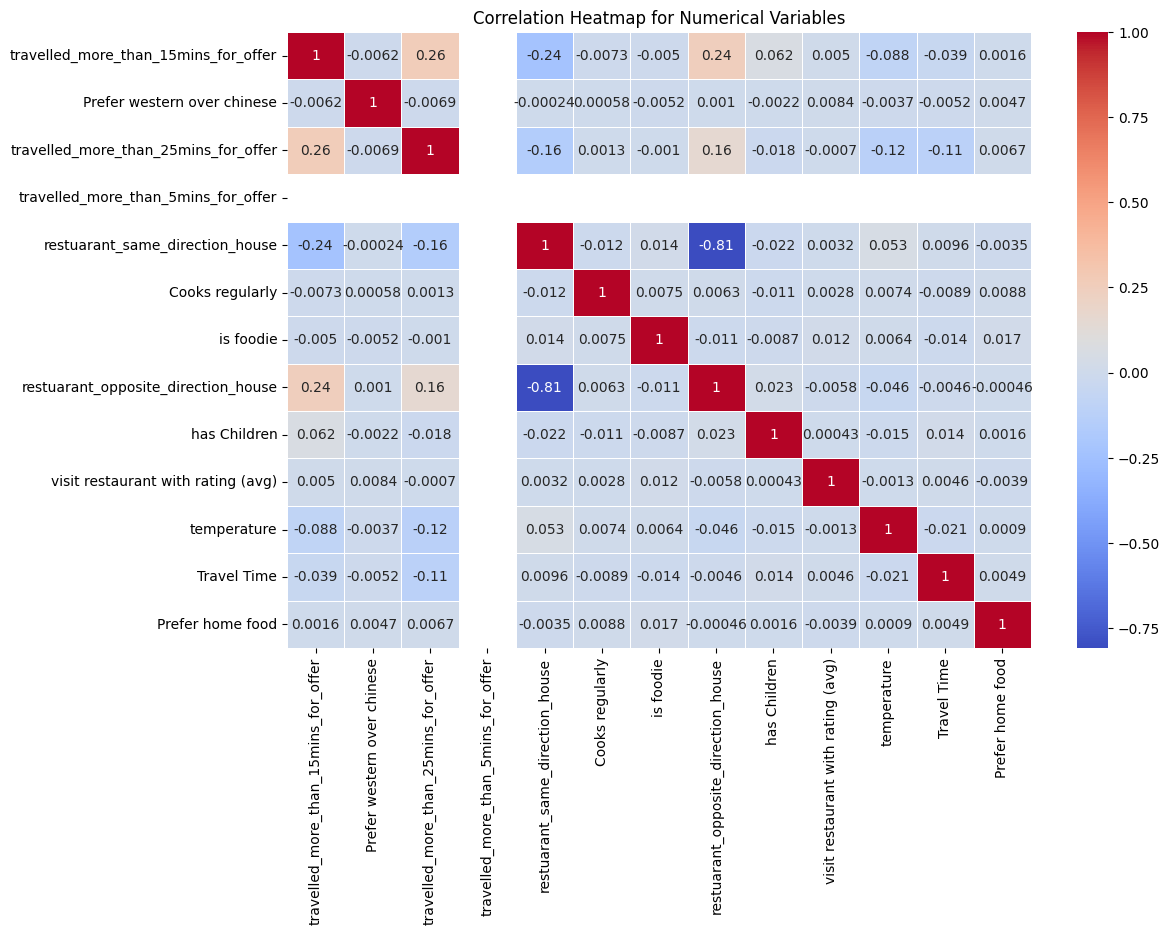

In [12]:
# Calculating the correlation matrix for numerical variables
correlation_matrix = data[numerical_columns].corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Correlation Heatmap for Numerical Variables')
plt.show()


- Multivariate Analysis

Analyzing More Than Two Variables 
(Scatter Plot for Multivariate Analysis)

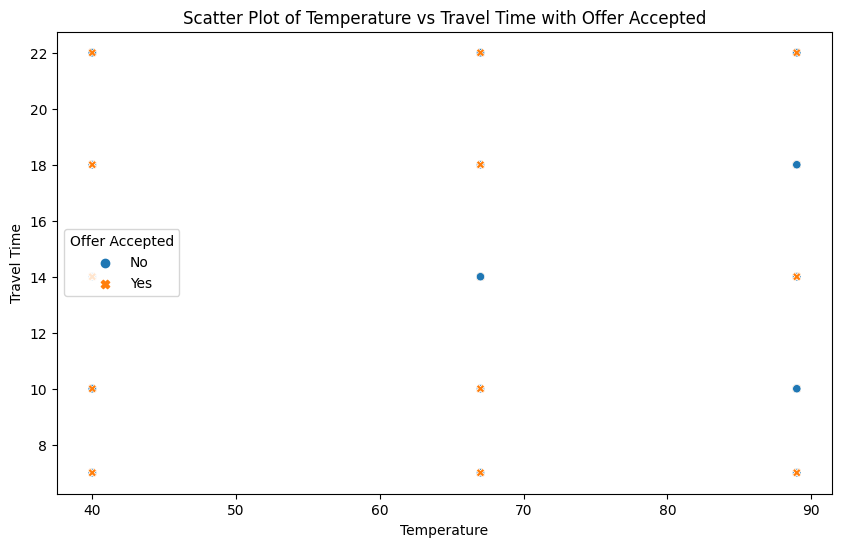

In [13]:
# Scatter plot for multivariate analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='Travel Time', hue='Offer Accepted', style='Offer Accepted', data=data)
plt.title('Scatter Plot of Temperature vs Travel Time with Offer Accepted')
plt.xlabel('Temperature')
plt.ylabel('Travel Time')
plt.legend(title='Offer Accepted')
plt.show()


- Outlier Detection

(Box plot for Outlier Detection)

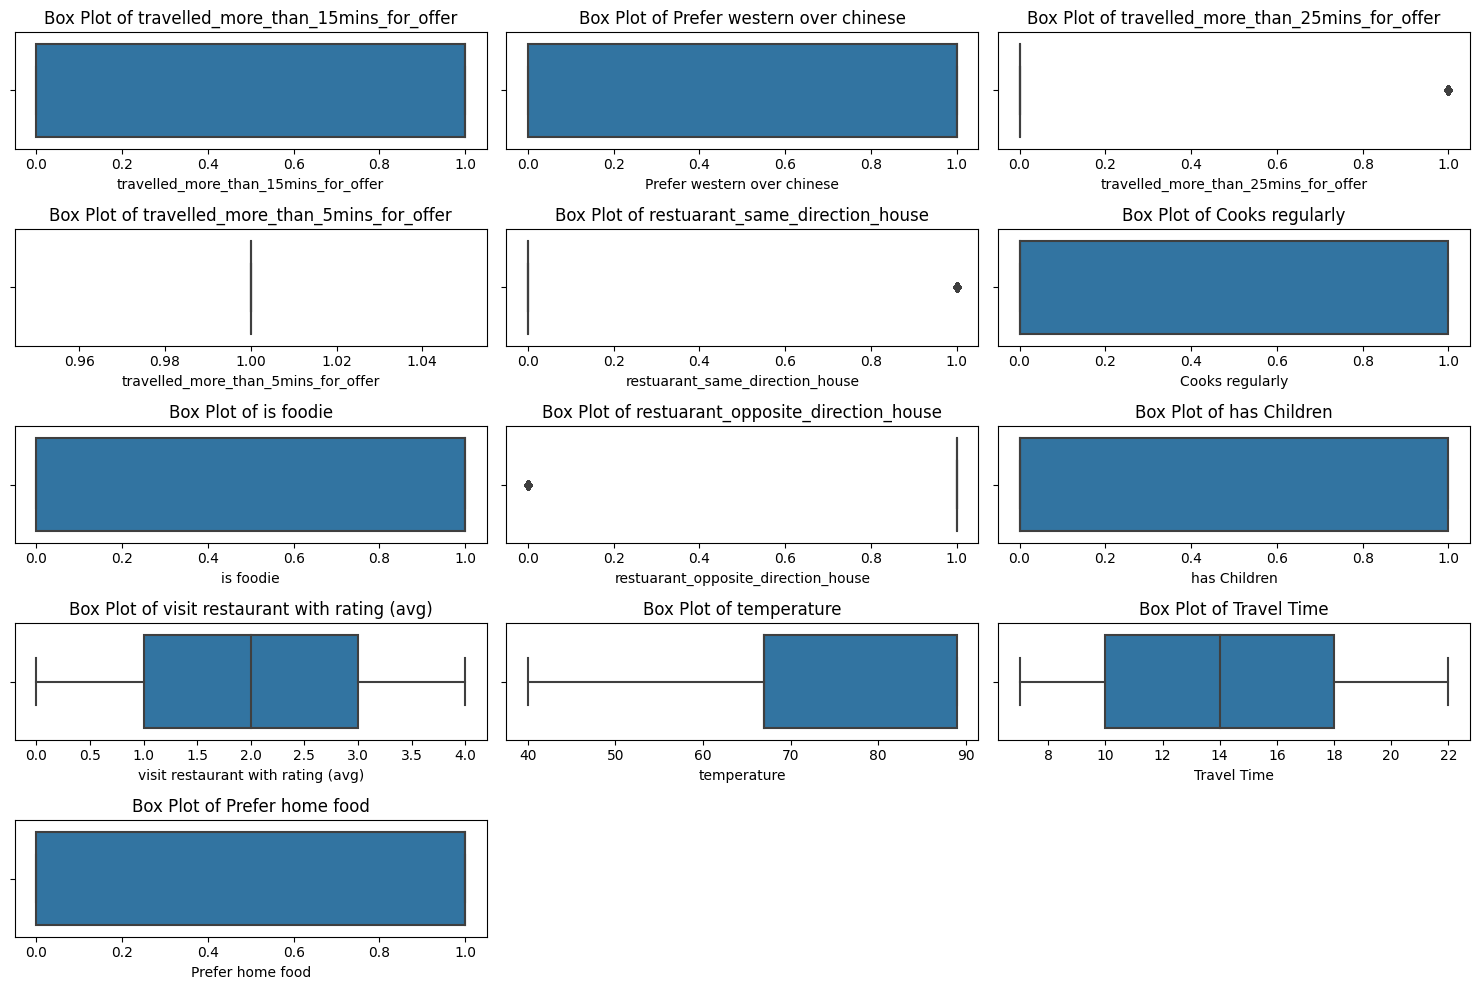

In [14]:
# Plotting box plots for numerical variables to identify outliers
plt.figure(figsize=(15, 10))
for idx, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 3, idx)
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()


**Cleaning & Feature Engineering**

In [20]:
unique_values_per_column = {col: df[col].unique() for col in df.columns}
allcols = df.columns
for col in allcols[:11]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

offer expiration :==> ['2days' '10hours']

income_range :==> ['₹100000 or More' '₹87500 - ₹99999' '₹37500 - ₹49999' 'Less than ₹12500'
 '₹50000 - ₹62499' '₹12500 - ₹24999' '₹75000 - ₹87499' '₹25000 - ₹37499'
 '₹62500 - ₹74999']

no_visited_Cold drinks :==> ['4~8' 'less1' 'never' '1~3' 'gt8' nan]

travelled_more_than_15mins_for_offer :==> [1 0]

Restaur_spend_less_than20 :==> ['less1' '4~8' '1~3' 'gt8' 'never' nan]

Marital Status :==> ['Married partner' 'Single' 'Divorced' 'Unmarried partner' 'Widowed']

restaurant type :==> ['4 star restaurant' 'Take-away restaurant' 'Cold drinks'
 'Restaurant with pub' '2 star restaurant']

age :==> ['36' '50plus' '26' '46' '21' 'below21' '41' '31']

Prefer western over chinese :==> [0 1]

travelled_more_than_25mins_for_offer :==> [0 1]

travelled_more_than_5mins_for_offer :==> [1]



In [23]:
for col in allcols[11:20]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

no_visited_bars :==> ['less1' 'never' '1~3' nan '4~8' 'gt8']

gender :==> ['Female' 'Male']

car :==> [nan 'Mazda5' 'Car that is too old to install Onstar :D' 'crossover'
 'Scooter and motorcycle' 'do not drive']

restuarant_same_direction_house :==> [0 1]

Cooks regularly :==> [1 0]

Customer type :==> ['Individual' 'With Family' 'With Kids' 'With Colleagues']

Qualification :==> ['Bachelors degree' 'Some college - no degree'
 'Graduate degree (Masters or Doctorate)' 'Associates degree'
 'High School Graduate' 'Some High School']

is foodie :==> [0 1]

no_Take-aways :==> ['1~3' 'gt8' '4~8' 'less1' nan 'never']



In [25]:
for col in allcols[20:21]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

Job/Job Industry :==> ['Unemployed' 'Arts Design Entertainment Sports & Media' 'Sales & Related'
 'Student' 'Business & Financial' 'Computer & Mathematical'
 'Office & Administrative Support' 'Management' 'Healthcare Support'
 'Life Physical Social Science' 'Installation Maintenance & Repair'
 'Legal' 'Community & Social Services' 'Education&Training&Library'
 'Construction & Extraction' 'Healthcare Practitioners & Technical'
 'Transportation & Material Moving' 'Retired' 'Architecture & Engineering'
 'Production Occupations' 'Farming Fishing & Forestry'
 'Protective Service' 'Personal Care & Service'
 'Food Preparation & Serving Related'
 'Building & Grounds Cleaning & Maintenance']



In [22]:
for col in allcols[21:]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

restuarant_opposite_direction_house :==> [0 1]

has Children :==> [0 1]

visit restaurant with rating (avg) :==> [4 3 0 1 2]

temperature :==> [67 89 40]

Restaur_spend_greater_than20 :==> ['less1' '1~3' 'never' 'gt8' nan '4~8']

Travel Time :==> [22 18  7 10 14]

Climate :==> ['Spring' 'Summer' 'Winter']

drop location :==> ['Location B' 'Location A' 'Location C']

Prefer home food :==> [0 1]

Offer Accepted :==> ['No' 'Yes']

